In [1]:
import numpy as np
import matplotlib.pyplot as plt

import copy
from copy import deepcopy

import torch
import torch.nn as nn
# from models import EncoderDecoder, Encoder, Decoder, TransformerLayer, EmbeddingsWithPositionalEncoding
# from mha import MultiHeadAttention
# from feed_forward import FeedForward
# from positional_encoding import get_positional_encoding


In [2]:
def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = torch.triu(torch.ones(attn_shape), diagonal=1).type(
        torch.uint8
    )
    return subsequent_mask == 0

class Batch:
    """Object for holding a batch of data with mask during training."""

    def __init__(self, src, tgt=None, pad=2):  # 2 = <blank>
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if tgt is not None:
            self.tgt = tgt[:, :-1]
            self.tgt_y = tgt[:, 1:]
            self.tgt_mask = self.make_std_mask(self.tgt, pad)
            self.ntokens = (self.tgt_y != pad).data.sum()

    @staticmethod
    def make_std_mask(tgt, pad):
        "Create a mask to hide padding and future words."
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & subsequent_mask(tgt.size(-1)).type_as(
            tgt_mask.data
        )
        return tgt_mask

## Genearate data

In [3]:
def data_gen(V, batch_size, n_batches):
    "Generate random data for a src-tgt copy task."
    for i in range(n_batches):
        data = torch.randint(1, V, size=(batch_size, 10))
        data[:, 0] = 1
        src = data.requires_grad_(False).clone().detach()
        tgt = data.requires_grad_(False).clone().detach()
        yield Batch(src, tgt, 0)

- Batch_size: 80
- length: 10

In [4]:
data_iter = data_gen(V=11, batch_size=80, n_batches=20)

# Try to get next batch from the existing generator
batch = next(data_iter)

# Display batch information
print(f"Batch source shape: {batch.src.shape}")
print(f"Batch target shape: {batch.tgt.shape}")
print(f"Batch source mask shape: {batch.src_mask.shape}")
print(f"Batch target mask shape: {batch.tgt_mask.shape}")
print(f"Number of tokens: {batch.ntokens}")

Batch source shape: torch.Size([80, 10])
Batch target shape: torch.Size([80, 9])
Batch source mask shape: torch.Size([80, 1, 10])
Batch target mask shape: torch.Size([80, 9, 9])
Number of tokens: 720


## Embedding

Create a new dimension with `d_model` size.

In [5]:
embed = nn.Embedding(11, 512)
token_embedded = embed(batch.src)
token_embedded.shape

torch.Size([80, 10, 512])

## Positional Encoding

In [6]:
from positional_encoding import get_positional_encoding

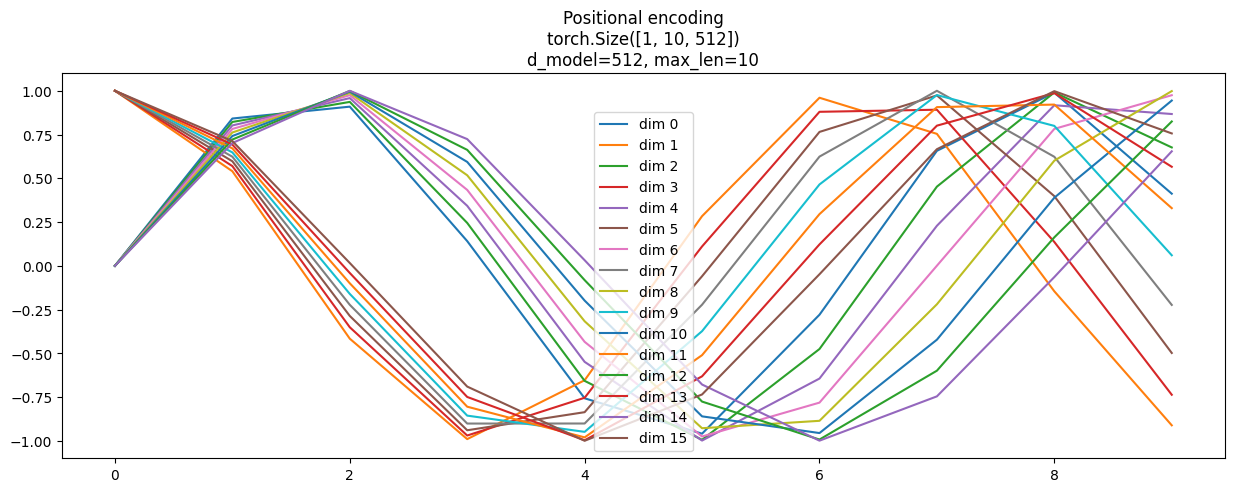

In [7]:
max_len = 10
pe = get_positional_encoding(d_model=512, max_len=max_len)

plt.figure(figsize=(15, 5))
plt.plot(np.arange(max_len), pe[0, :, :16].numpy())
plt.legend(["dim %d" % p for p in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]])
plt.title(f"Positional encoding\n{pe.shape}\nd_model=512, max_len={max_len}")
plt.show()

## Embedding + Positional Encoding

In [8]:
from models import EmbeddingsWithPositionalEncoding

In [9]:
embed_with_pe = EmbeddingsWithPositionalEncoding(d_model=512, n_vocab=11, max_len=max_len)
src_embedded_pe = embed_with_pe(batch.src)
src_embedded_pe.shape

torch.Size([80, 10, 512])

## Multi-Head Attention

In [10]:
from mha import MultiHeadAttention

In [11]:
mha = MultiHeadAttention(d_model=512,n_heads=8)

multi-head attention output

In [12]:
mha(query=src_embedded_pe, key=src_embedded_pe, value=src_embedded_pe, mask=None).shape

torch.Size([80, 10, 512])

attention shape

In [13]:
mha.attn.shape

torch.Size([80, 10, 10, 8])

## Feed Forward

In [14]:
from feed_forward import FeedForward

In [15]:
ff = FeedForward(d_model=512, d_ff=2048, dropout=0.1)
ff

FeedForward(
  (layer1): Linear(in_features=512, out_features=2048, bias=True)
  (layer2): Linear(in_features=2048, out_features=512, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (activation): ReLU()
)

## Encoder Layer

In [16]:
from models import TransformerLayer

In [17]:
encoder_layer = TransformerLayer(
                    d_model=512, 
                    self_attn=MultiHeadAttention(d_model=512, n_heads=8, dropout_prob=0.1), 
                    feed_forward=FeedForward(d_model=512, d_ff=2048, dropout=0.1),
                    dropout_prob=0.1
                )
encoder_layer

TransformerLayer(
  (self_attn): MultiHeadAttention(
    (query): PrepareForMultiHeadAttention(
      (linear): Linear(in_features=512, out_features=512, bias=True)
    )
    (key): PrepareForMultiHeadAttention(
      (linear): Linear(in_features=512, out_features=512, bias=True)
    )
    (value): PrepareForMultiHeadAttention(
      (linear): Linear(in_features=512, out_features=512, bias=True)
    )
    (softmax): Softmax(dim=-1)
    (output): Linear(in_features=512, out_features=512, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (feed_forward): FeedForward(
    (layer1): Linear(in_features=512, out_features=2048, bias=True)
    (layer2): Linear(in_features=2048, out_features=512, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (activation): ReLU()
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (norm_self_attn): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (norm_ff): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
)

In [18]:
batch.src_mask.shape

torch.Size([80, 1, 10])

In [19]:
encoder_layer(x=src_embedded_pe, mask=batch.src_mask).shape

torch.Size([80, 10, 512])

## Decoder Layer

In [20]:
from models import TransformerLayer

In [21]:
tgt_embedded_pe = embed_with_pe(batch.tgt)
tgt_embedded_pe.shape

torch.Size([80, 9, 512])

In [22]:
decoder_layer = TransformerLayer(
                    d_model=512,
                    self_attn=MultiHeadAttention(d_model=512, n_heads=8, dropout_prob=0.1),
                    src_attn=MultiHeadAttention(d_model=512, n_heads=8, dropout_prob=0.1),
                    feed_forward=FeedForward(d_model=512, d_ff=2048, dropout=0.1),
                    dropout_prob=0.1
                )

In [23]:
decoder_layer(
    x=tgt_embedded_pe,
    mask=batch.tgt_mask,
    src=src_embedded_pe,
    src_mask=batch.src_mask
).shape

torch.Size([80, 9, 512])

## Encoder

In [24]:
from models import Encoder

In [25]:
en_layer = TransformerLayer(
                d_model=512,
                self_attn=MultiHeadAttention(d_model=512, n_heads=8, dropout_prob=0.1), 
                feed_forward=FeedForward(d_model=512, d_ff=2048, dropout=0.1),
                dropout_prob=0.1
            )

In [26]:
encoder = Encoder(layer=en_layer, n_layers=6)
encoder

Encoder(
  (layers): ModuleList(
    (0-5): 6 x TransformerLayer(
      (self_attn): MultiHeadAttention(
        (query): PrepareForMultiHeadAttention(
          (linear): Linear(in_features=512, out_features=512, bias=True)
        )
        (key): PrepareForMultiHeadAttention(
          (linear): Linear(in_features=512, out_features=512, bias=True)
        )
        (value): PrepareForMultiHeadAttention(
          (linear): Linear(in_features=512, out_features=512, bias=True)
        )
        (softmax): Softmax(dim=-1)
        (output): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (feed_forward): FeedForward(
        (layer1): Linear(in_features=512, out_features=2048, bias=True)
        (layer2): Linear(in_features=2048, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (activation): ReLU()
      )
      (dropout): Dropout(p=0.1, inplace=False)
      (norm_self_attn): LayerNor

In [27]:
memory = encoder(x=src_embedded_pe, mask=batch.src_mask)
memory.shape

torch.Size([80, 10, 512])

## Decoder

In [28]:
from models import Encoder, Decoder

In [29]:
decoder_layer = TransformerLayer(
                    d_model=512,
                    self_attn=MultiHeadAttention(d_model=512, n_heads=8, dropout_prob=0.1),
                    src_attn=MultiHeadAttention(d_model=512, n_heads=8, dropout_prob=0.1),
                    feed_forward=FeedForward(d_model=512, d_ff=2048, dropout=0.1),
                    dropout_prob=0.1
                )

In [30]:
decoder = Decoder(layer=decoder_layer, n_layers=6)
decoder

Decoder(
  (layers): ModuleList(
    (0-5): 6 x TransformerLayer(
      (self_attn): MultiHeadAttention(
        (query): PrepareForMultiHeadAttention(
          (linear): Linear(in_features=512, out_features=512, bias=True)
        )
        (key): PrepareForMultiHeadAttention(
          (linear): Linear(in_features=512, out_features=512, bias=True)
        )
        (value): PrepareForMultiHeadAttention(
          (linear): Linear(in_features=512, out_features=512, bias=True)
        )
        (softmax): Softmax(dim=-1)
        (output): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (src_attn): MultiHeadAttention(
        (query): PrepareForMultiHeadAttention(
          (linear): Linear(in_features=512, out_features=512, bias=True)
        )
        (key): PrepareForMultiHeadAttention(
          (linear): Linear(in_features=512, out_features=512, bias=True)
        )
        (value): PrepareForMultiHeadAttention(
 

In [31]:
decoder(
    x=tgt_embedded_pe,
    memory=memory,
    src_mask=batch.src_mask,
    tgt_mask = batch.tgt_mask
).shape

torch.Size([80, 9, 512])

## EncoderDecoder

In [32]:
from models import EncoderDecoder, Encoder, Decoder, Generator, EmbeddingsWithPositionalEncoding

In [33]:
d_model = 512
n_heads = 8
dropout_prob = 0.1
src_vocab_size = 11
tgt_vocab_size = 11

encoder = Encoder(
                layer=TransformerLayer(
                    d_model=d_model,
                    self_attn=MultiHeadAttention(d_model=d_model, n_heads=n_heads, dropout_prob=0.1), 
                    feed_forward=FeedForward(d_model=d_model, d_ff=2048, dropout=0.1),
                    dropout_prob=0.1),
                n_layers=6
            )
decoder = Decoder(
                layer=TransformerLayer(
                    d_model=d_model,
                    self_attn=MultiHeadAttention(d_model=d_model, n_heads=n_heads, dropout_prob=0.1),
                    src_attn=MultiHeadAttention(d_model=d_model, n_heads=n_heads, dropout_prob=0.1),
                    feed_forward=FeedForward(d_model=d_model, d_ff=2048, dropout=0.1),
                    dropout_prob=0.1
                ), 
                n_layers=6
            )

src_embed = EmbeddingsWithPositionalEncoding(d_model=d_model, n_vocab=src_vocab_size, max_len=10)
tgt_embed = EmbeddingsWithPositionalEncoding(d_model=d_model, n_vocab=tgt_vocab_size, max_len=10)

generator = Generator(d_model=d_model, n_vocab=tgt_vocab_size)

In [34]:
model = EncoderDecoder(
            encoder=encoder,
            decoder=decoder,
            src_embed=src_embed,
            tgt_embed=tgt_embed,
            generator=generator
        )

In [35]:
model

EncoderDecoder(
  (encoder): Encoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerLayer(
        (self_attn): MultiHeadAttention(
          (query): PrepareForMultiHeadAttention(
            (linear): Linear(in_features=512, out_features=512, bias=True)
          )
          (key): PrepareForMultiHeadAttention(
            (linear): Linear(in_features=512, out_features=512, bias=True)
          )
          (value): PrepareForMultiHeadAttention(
            (linear): Linear(in_features=512, out_features=512, bias=True)
          )
          (softmax): Softmax(dim=-1)
          (output): Linear(in_features=512, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feed_forward): FeedForward(
          (layer1): Linear(in_features=512, out_features=2048, bias=True)
          (layer2): Linear(in_features=2048, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (activation): ReLU()
        )
      

---

```Python
model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab),
    )
```